In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn import random_projection
import neurokit2 as nk
import cccrt
from IPython.display import Audio
import librosa
import librosa.display

/home/ck84/miniconda3/envs/conda39/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
#data: string frequencies, pt1, pt2
wavmeta = {
    0:{'freqs':[60], 'pt0':4.3, 'pt1':7.5, 'pt2':12.4,},
    1:{'freqs':[120], 'pt0':5.1, 'pt1':6.4, 'pt2':13.2},
    2:{'freqs':[240], 'pt0':5.2, 'pt1':8.4, 'pt2':13.2},
    3:{'freqs':[480], 'pt0':4.0, 'pt1':9.8, 'pt2':14.4},
    4:{'freqs':[960], 'pt0':3.7, 'pt1':9.3, 'pt2':15.4},
    5:{'freqs':[34,38,46], 'pt0':5.1, 'pt1':7.4, 'pt2':13.0, 'midi':1},
    6:{'freqs':[34,41,46], 'pt0':4.8, 'pt1':7.3, 'pt2':13.0, 'midi':1},
    7:{'freqs':[39,46,51], 'pt0':2.6, 'pt1':5, 'pt2':9.0, 'midi':1},
    8:{'freqs':[49, 53, 56, 61], 'pt0':5.0, 'pt1':9, 'pt2':14.0, 'midi':1},
    9:{'freqs':[57, 61, 64, 67, 69], 'pt0':2.1, 'pt1':7.7, 'pt2':11.4, 'midi':1},
    10:{'freqs':[68, 66, 5, 5, 43, 13], 'pt0':4.6, 'pt1':7.6, 'pt2':14.9, 'midi':1},
    11:{'freqs':[69, 36, 9, 16, 35, 47], 'pt0':4.2, 'pt1':9.4, 'pt2':14.3, 'midi':1},
    12:{'freqs':[33, 22, 59, 22, 8, 49 ], 'pt0':2.5, 'pt1':6.8, 'pt2':11.6, 'midi':1},
    13:{'freqs':[52, 57, 49, 8, 41, 31 ], 'pt0':7.1, 'pt1':9.3, 'pt2':14.9, 'midi':1},
    14:{'freqs':[22, 35, 49, 21, 9, 65  ], 'pt0':3.8, 'pt1':7.5, 'pt2':11.8, 'midi':1},
          }

In [5]:
wavs = [librosa.load(f"study2audio/fb_{x}.wav", sr=None, mono=False, dtype=double)[0][:48000*18] for x in arange(15)]
sr = 48000
# wav = wav / max(abs(wav))
print("loaded",sr)

loaded 48000


In [6]:
[len(x) for x in wavs]

[864000,
 864000,
 864000,
 864000,
 864000,
 864000,
 864000,
 864000,
 864000,
 864000,
 864000,
 864000,
 864000,
 864000,
 864000]

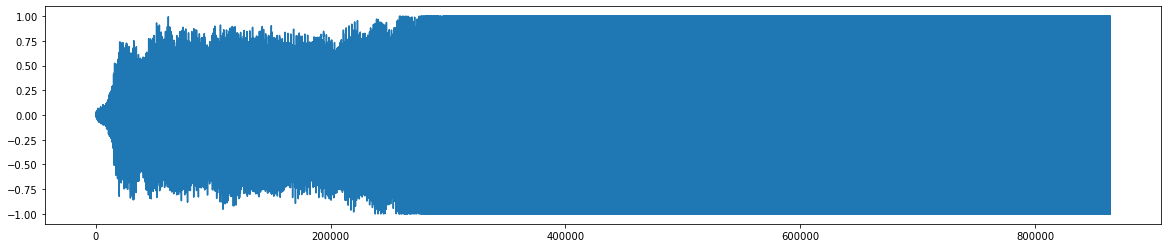

In [7]:
figsize(20,4)
plot(wavs[0])
Audio(wavs[0],rate=sr)

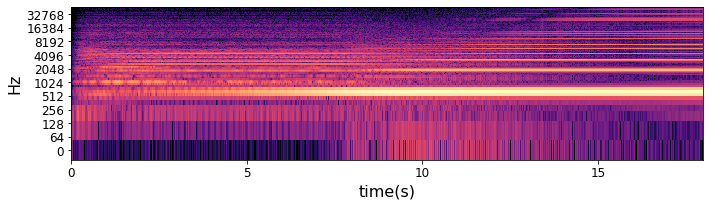

In [8]:
figsize(10,3)
matplotlib.rcParams.update({'font.size': 12})
D = np.abs(librosa.stft(np.asfortranarray(wavs[6]), n_fft=1024))
librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max), y_axis='log', x_axis='time', sr=sr*2)
# plt.title('')
# plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
xlabel("time(s)", fontsize=16)
ylabel("Hz", fontsize=16)
plt.savefig("spec.pdf")

In [9]:
def quantise(v, symcount):
    return array((v-np.min(v))/np.max(v) * symcount * 0.999999999, dtype=int)

quantise(arange(-1,1,0.1),5)

array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  6,  6,  7,  7,  8,  8,
        9,  9, 10])

In [10]:
def runFeatureOnWindows(sig, winsize, hopsize, feature):
    offset=0
    res = []
    while offset + winsize < len(sig):
        feat = feature(sig[offset:offset+winsize])
        res.append(feat)
        # print(offset / len(sig), ": ", feat)
        offset += hopsize
    return res

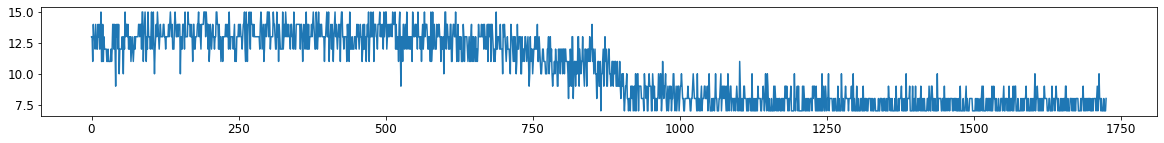

In [11]:
figsize(20,2)
def makeRPC_cccrt(h,l,beta, alpha=0.5):
    def calcRPC(win): 
        return cccrt.RPC(calcRPC.proj, win, beta, alpha) 
    calcRPC.proj = cccrt.createRPMatrix(h,l)
    return calcRPC

featRPC2Db = runFeatureOnWindows(array(wavs[9], dtype=double), 1000, 500, makeRPC_cccrt(64,4,3,1))
plot(featRPC2Db)

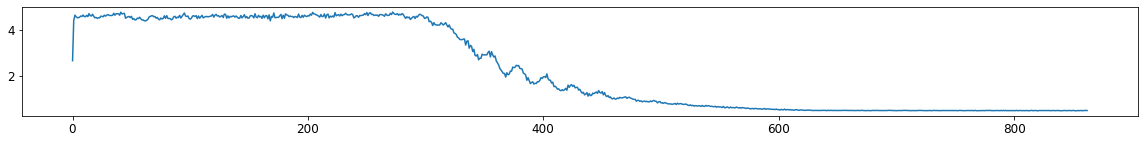

In [12]:
def calcLZ(win): 
    winQ = quantise(win, 256)
    return cccrt.NLZ(winQ) 


featLZ = runFeatureOnWindows(wavs[0], 1000, 1000, calcLZ)
plot(featLZ)

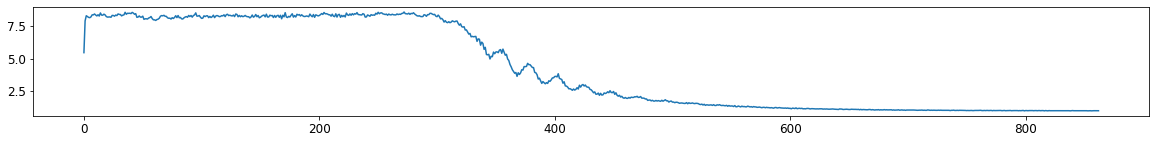

In [13]:
def calcShannon(win): 
    winQ = quantise(win, 256)
    return cccrt.shannonEntropy(winQ) 


featShannon = runFeatureOnWindows(wavs[0], 1000, 1000, calcShannon)
plot(featShannon)

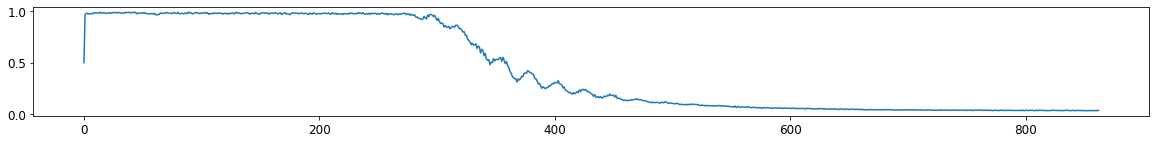

In [14]:
def calcETC(win): 
    winQ = quantise(win, 256)
    return cccrt.ETC(winQ) 


featETC = runFeatureOnWindows(wavs[0], 1000, 1000, calcETC)
plot(featETC)


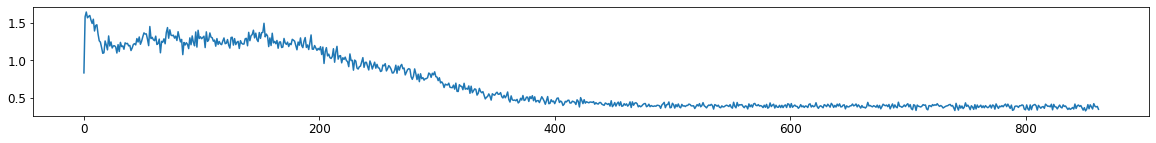

In [15]:
def calcMSE(win): 
    return nk.entropy_multiscale(win)[0]


featMSE = runFeatureOnWindows(wavs[0], 1000, 1000, calcMSE)
plot(featMSE)

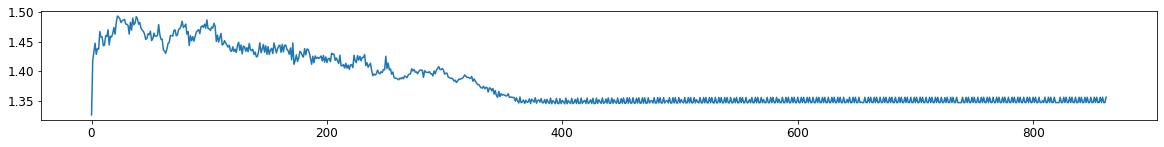

In [16]:
def calcSevcik(win): 
    return cccrt.sevcik(win)


featMSE = runFeatureOnWindows(wavs[0], 1000, 1000, calcSevcik)
plot(featMSE)

In [17]:
conditions=[makeRPC_cccrt(32,1,100), makeRPC_cccrt(16,4,10), makeRPC_cccrt(64,7,3), makeRPC_cccrt(64,7,3,1), calcLZ, calcShannon, calcETC, calcMSE, calcSevcik]

In [18]:
def runMetrics():
    res = {}
    for i_wav, wav in enumerate(wavs):
        wavResults = {}
        for i, metric in enumerate(conditions):
            print(i_wav, metric)
            feat = runFeatureOnWindows(wav, 1000, 500, metric)
            wavResults[f'cond_{metric.__name__}_{i}'] = feat
        res[i_wav] = wavResults
    return res

res = runMetrics()

0 <function makeRPC_cccrt.<locals>.calcRPC at 0x7ffb2f4a4430>
0 <function makeRPC_cccrt.<locals>.calcRPC at 0x7ffb2f4a4310>
0 <function makeRPC_cccrt.<locals>.calcRPC at 0x7ffb2f4a4af0>
0 <function makeRPC_cccrt.<locals>.calcRPC at 0x7ffb2f404430>
0 <function calcLZ at 0x7ffb341410d0>
0 <function calcShannon at 0x7ffb340fbd30>
0 <function calcETC at 0x7ffb3405b9d0>
0 <function calcMSE at 0x7ffb340523a0>
0 <function calcSevcik at 0x7ffb2f4a4160>
1 <function makeRPC_cccrt.<locals>.calcRPC at 0x7ffb2f4a4430>
1 <function makeRPC_cccrt.<locals>.calcRPC at 0x7ffb2f4a4310>
1 <function makeRPC_cccrt.<locals>.calcRPC at 0x7ffb2f4a4af0>
1 <function makeRPC_cccrt.<locals>.calcRPC at 0x7ffb2f404430>
1 <function calcLZ at 0x7ffb341410d0>
1 <function calcShannon at 0x7ffb340fbd30>
1 <function calcETC at 0x7ffb3405b9d0>
1 <function calcMSE at 0x7ffb340523a0>
1 <function calcSevcik at 0x7ffb2f4a4160>
2 <function makeRPC_cccrt.<locals>.calcRPC at 0x7ffb2f4a4430>
2 <function makeRPC_cccrt.<locals>.calcR

In [19]:
import seaborn as sns
from sklearn.preprocessing import scale
matplotlib.rcParams.update({'font.size': 16})
figsize(20,4)

In [20]:
res[0].keys()

dict_keys(['cond_calcRPC_0', 'cond_calcRPC_1', 'cond_calcRPC_2', 'cond_calcRPC_3', 'cond_calcLZ_4', 'cond_calcShannon_5', 'cond_calcETC_6', 'cond_calcMSE_7', 'cond_calcSevcik_8'])

In [21]:
w = res[0]['cond_calcRPC_0']

In [22]:
def timeToPos(wav, secs):
    wavLenInSamples = len(wav)
    wavLenInSecs = wavLenInSamples / sr
    pos =secs / wavLenInSecs
    return pos
timeToPos(wavs[0], 20)

1.1111111111111112

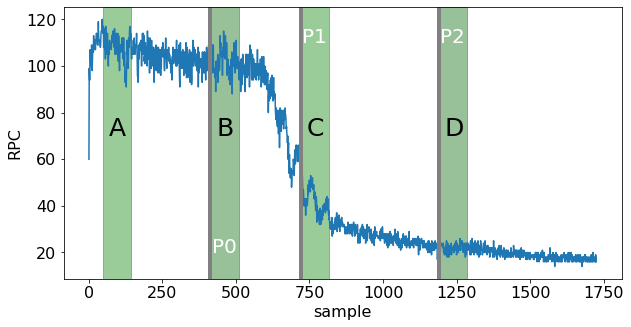

In [24]:
figsize(10,5)
widx=0
# plot(res[0]['cond_calcRPC_0'])
feat = res[widx]['cond_calcRPC_1']
plot(feat)
# plot(res[0]['cond_calcRPC_2'])
# plot(res[0]['cond_calcSevcik_7'])

lsecs = len(wavs[widx])/sr
lOneSec =round(len(feat)/lsecs)

pt0 = wavmeta[widx]['pt0'] * lOneSec
plt.axvspan(pt0, pt0+lOneSec, color='darkgreen', alpha=0.4)
plt.text(pt0+20,70,'B', fontsize=25)

plt.axvspan(48, 48+96, color='green', alpha=0.4)
plt.text(0.2*lOneSec+48,70,'A', fontsize=25)
pt1 = wavmeta[widx]['pt1'] * lOneSec
plt.axvspan(pt1, pt1+lOneSec, color='green', alpha=0.4)
plt.text(pt1+20,70,'C', fontsize=25)
pt2 = wavmeta[widx]['pt2'] * lOneSec
plt.axvspan(pt2, pt2+lOneSec, color='darkgreen', alpha=0.4)
plt.text(pt2+20,70,'D', fontsize=25)
# plt.tight_layout()

plt.axvline(x = pt0, color = 'grey', lw=4,label = 'P0')
plt.axvline(x = pt1, color = 'grey', lw=4,label = 'P1')
plt.axvline(x = pt2, color = 'grey', lw=4, label = 'P2')
plt.text(pt0+5,20,'P0', fontsize=20, color='white')
plt.text(pt1+5,110,'P1', fontsize=20, color='white')
plt.text(pt2+5,110,'P2', fontsize=20, color='white')
 
xlabel("sample")
ylabel("RPC")
plt.savefig("rois.pdf")



In [25]:
def timeToFeatPos(wav, secs, feat):
    return int(floor(timeToPos(wav, secs) * len(feat)))
def extractROIs(wavIdx, feat):
    n0=0
    n1=96
    sec1 = feat[48:48+n1]
    n0=timeToFeatPos(wavs[wavIdx],wavmeta[wavIdx]['pt0'], feat)
    sec0 = feat[n0:n0+n1]
    n0=timeToFeatPos(wavs[wavIdx],wavmeta[wavIdx]['pt1']-1.0, feat)
    # sec2a = feat[n0:n0+n1]
    # n0=timeToFeatPos(wavs[wavIdx],wavmeta[wavIdx]['pt1'], feat)
    sec2b = feat[n0:n0+n1]
    n0=timeToFeatPos(wavs[wavIdx],wavmeta[wavIdx]['pt2'], feat)
    sec3 = feat[n0:n0+n1]
    return [sec1, sec0, sec2b, sec3]
rois = extractROIs(0, scale(res[0]['cond_calcRPC_1']))
# rois = extractROIs(0, res[0]['cond_calcSevcik_7'])


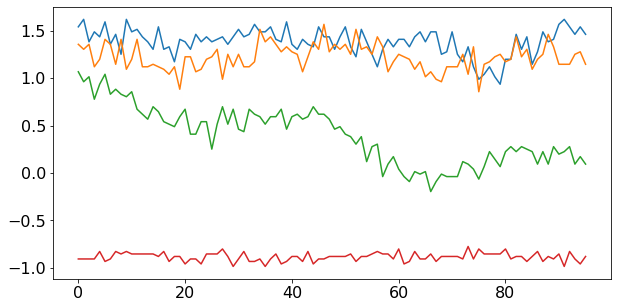

In [26]:
plot(rois[0])
plot(rois[1])
plot(rois[2])
plot(rois[3])


In [27]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [28]:
dtw(rois[0], rois[1], keep_internals=False).normalizedDistance

0.0685837925458685

In [29]:
import scipy

In [30]:
import scipy.spatial as sp

In [31]:
metricRename = {'cond_calcRPC_0':'RPC0', 'cond_calcRPC_1':'RPC1', 'cond_calcRPC_2':'RPC2', 'cond_calcRPC_3':'RPC3',
               'cond_calcLZ_4':'LZ',
              'cond_calcShannon_5':'SE',
                'cond_calcETC_6':'ETC',
                'cond_calcMSE_7':'MSE',
                'cond_calcSevcik_8':'SFD'
                
               }

In [32]:
tests={}
idx=0
for wav in res:
    print(wav)
    # tests[wav] = {}
    # resDists = []
    for m in res[wav]:
        print(m)
        rois = extractROIs(wav, scale(res[wav][m]))
        print(len(rois[0]), len(rois[1]),len(rois[2]),len(rois[3]))
        def addRow(testType, value):
            global idx
            testsd = {}
            testsd['wav'] = wav
            testsd['Metric'] = metricRename[m]
            testsd['Test'] = testType
            testsd['DTW Distance'] = value
            tests[idx] = testsd
            print(testsd)
            idx = idx + 1

        # addRow('AB', cosineDist(rois[0], rois[1]))
        # addRow('BC', cosineDist(rois[1], rois[2]))
        # addRow('AC', cosineDist(rois[0], rois[2]))
        # addRow('CD', cosineDist(rois[2], rois[3]))
        addRow('AB', dtw((rois[0]), (rois[1]), keep_internals=False).normalizedDistance)
        addRow('BC', dtw((rois[1]), (rois[2]), keep_internals=False).normalizedDistance)
        addRow('AC', dtw((rois[0]), (rois[2]), keep_internals=False).normalizedDistance)
        addRow('CD', dtw((rois[2]), (rois[3]), keep_internals=False).normalizedDistance)
        
        

0
cond_calcRPC_0
96 96 96 96
{'wav': 0, 'Metric': 'RPC0', 'Test': 'AB', 'DTW Distance': 0.11462803053487682}
{'wav': 0, 'Metric': 'RPC0', 'Test': 'BC', 'DTW Distance': 0.1211515769880812}
{'wav': 0, 'Metric': 'RPC0', 'Test': 'AC', 'DTW Distance': 0.12720915583748524}
{'wav': 0, 'Metric': 'RPC0', 'Test': 'CD', 'DTW Distance': 1.3140286427168804}
cond_calcRPC_1
96 96 96 96
{'wav': 0, 'Metric': 'RPC1', 'Test': 'AB', 'DTW Distance': 0.0685837925458685}
{'wav': 0, 'Metric': 'RPC1', 'Test': 'BC', 'DTW Distance': 0.40589010957784466}
{'wav': 0, 'Metric': 'RPC1', 'Test': 'AC', 'DTW Distance': 0.5067808383329446}
{'wav': 0, 'Metric': 'RPC1', 'Test': 'CD', 'DTW Distance': 0.9749576257718052}
cond_calcRPC_2
96 96 96 96
{'wav': 0, 'Metric': 'RPC2', 'Test': 'AB', 'DTW Distance': 0.12102924819525102}
{'wav': 0, 'Metric': 'RPC2', 'Test': 'BC', 'DTW Distance': 0.2546876353326149}
{'wav': 0, 'Metric': 'RPC2', 'Test': 'AC', 'DTW Distance': 0.24205849639050195}
{'wav': 0, 'Metric': 'RPC2', 'Test': 'CD', 

In [34]:
tests

{0: {'wav': 0,
  'Metric': 'RPC0',
  'Test': 'AB',
  'DTW Distance': 0.11462803053487682},
 1: {'wav': 0,
  'Metric': 'RPC0',
  'Test': 'BC',
  'DTW Distance': 0.1211515769880812},
 2: {'wav': 0,
  'Metric': 'RPC0',
  'Test': 'AC',
  'DTW Distance': 0.12720915583748524},
 3: {'wav': 0,
  'Metric': 'RPC0',
  'Test': 'CD',
  'DTW Distance': 1.3140286427168804},
 4: {'wav': 0,
  'Metric': 'RPC1',
  'Test': 'AB',
  'DTW Distance': 0.0685837925458685},
 5: {'wav': 0,
  'Metric': 'RPC1',
  'Test': 'BC',
  'DTW Distance': 0.40589010957784466},
 6: {'wav': 0,
  'Metric': 'RPC1',
  'Test': 'AC',
  'DTW Distance': 0.5067808383329446},
 7: {'wav': 0,
  'Metric': 'RPC1',
  'Test': 'CD',
  'DTW Distance': 0.9749576257718052},
 8: {'wav': 0,
  'Metric': 'RPC2',
  'Test': 'AB',
  'DTW Distance': 0.12102924819525102},
 9: {'wav': 0,
  'Metric': 'RPC2',
  'Test': 'BC',
  'DTW Distance': 0.2546876353326149},
 10: {'wav': 0,
  'Metric': 'RPC2',
  'Test': 'AC',
  'DTW Distance': 0.24205849639050195},
 11:

In [35]:
import pandas as pd


In [36]:
d = pd.DataFrame.from_dict(tests, 'index')

In [37]:
d

,wav,Metric,Test,DTW Distance
0,0,RPC0,AB,0.114628
1,0,RPC0,BC,0.121152
2,0,RPC0,AC,0.127209
3,0,RPC0,CD,1.314029
4,0,RPC1,AB,0.068584
...,...,...,...,...
535,14,MSE,CD,0.053364
536,14,SFD,AB,0.320941
537,14,SFD,BC,0.921537
538,14,SFD,AC,1.557588


In [38]:
d.groupby('Metric').min()

,wav,Test,DTW Distance
Metric,,,
ETC,0,AB,0.002759
LZ,0,AB,0.006280
MSE,0,AB,0.043908
RPC0,0,AB,0.058788
RPC1,0,AB,0.020979
RPC2,0,AB,0.029075
RPC3,0,AB,0.010361
SE,0,AB,0.003919
SFD,0,AB,0.020557


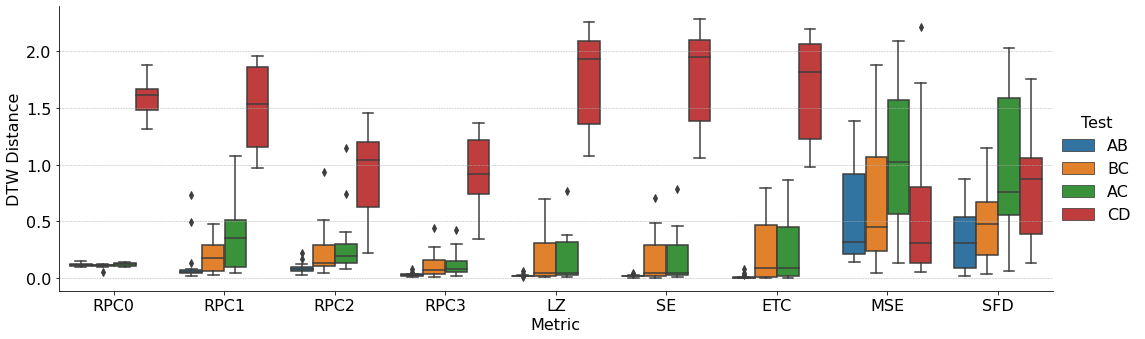

In [43]:
figsize(20,5)
sns.catplot(data=d, x='Metric', y='DTW Distance', hue='Test', kind='box', aspect=3)
# plt.tight_layout()
plt.grid(axis = 'y',linestyle = '--', linewidth = 0.5)
plt.savefig("s2dists.pdf")

In [44]:
scoutput = librosa.load(f"output/sctest.wav", sr=None, mono=False, dtype=double)[0]
print("loaded")

loaded


In [48]:
scoutput[0]

array([-0.12631586, -0.15947409, -0.20660637, ..., -0.15409938,
       -0.12239838, -0.09838346])

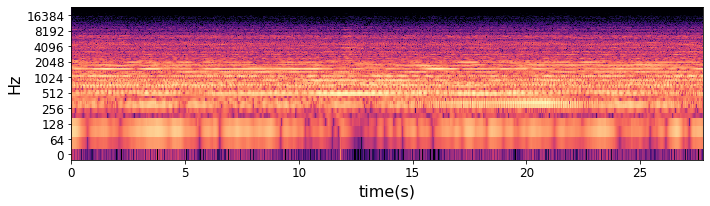

In [50]:
figsize(10,3)
matplotlib.rcParams.update({'font.size': 12})
D = np.abs(librosa.stft(np.asfortranarray(scoutput[0]), n_fft=1024))
librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max), y_axis='log', x_axis='time', sr=48000)
# plt.title('')
# plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
xlabel("time(s)", fontsize=16)
ylabel("Hz", fontsize=16)
plt.savefig("specOutput.pdf")